In [1]:

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from PIL import Image

from watson_developer_cloud import VisualRecognitionV3

if tf.__version__ != '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.0!')

# This is needed to display the images.
%matplotlib inline



/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Downloads the pretrained model

In [2]:
MODEL_NAME = 'faster_rcnn_resnet101_coco_2017_11_08'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

if not os.path.exists('pretrained_model'):
    os.mkdir('pretrained_model')

if not os.path.exists('pretrained_model/%s' % MODEL_NAME):
    opener = urllib.request.URLopener()
    opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, 'pretrained_model/%s.tar.gz' % MODEL_NAME)
    tar_file = tarfile.open('pretrained_model/%s.tar.gz' % MODEL_NAME)
    for file in tar_file.getmembers():
        file_name = os.path.basename(file.name)
        if 'frozen_inference_graph.pb' in file_name:
            tar_file.extract(file, 'pretrained_model')
    

### Loads the (frozen) Tensorflow model into memory.

In [3]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN = 'pretrained_model/%s/frozen_inference_graph.pb' % MODEL_NAME

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

### Set up Watson Visual Recognition

In [4]:
WATSON_API_KEY = '05572b8833ce3e4086391ffa8c55b50381ec6d15'

# Replace with your api key
visual_recognition = VisualRecognitionV3('2017-11-30', api_key=WATSON_API_KEY)

MAX_NUMBER_OF_BOXES = 10
MINIMUM_CONFIDENCE = 0.6

COLORS = ['b', 'g', 'r', 'c', 'm', 'y', 'b', 'w']

### Detection

Opening file: 'images/monkey.jpg'
+ Detecting objects
+ Classifying objects
Writing image to 'images/output_monkey.jpg'


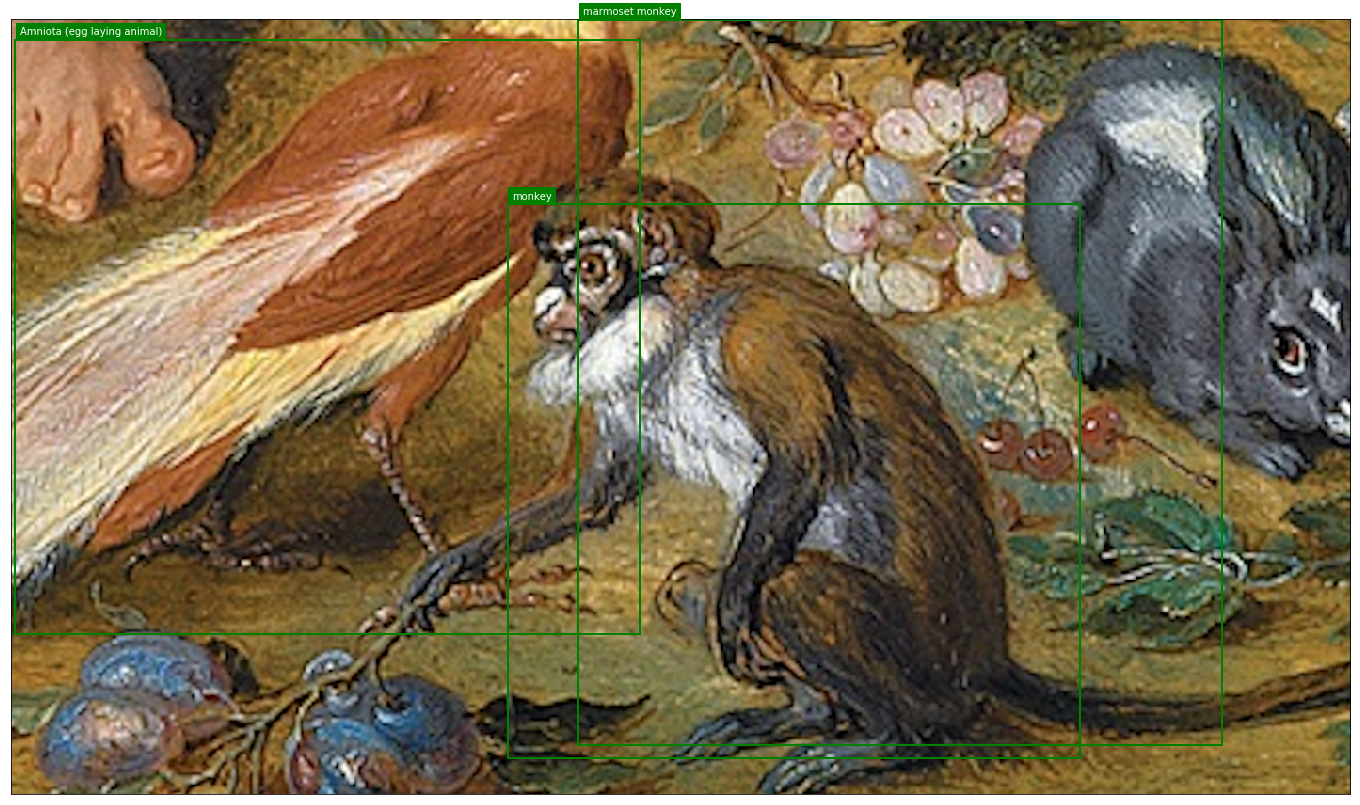

In [8]:
import scipy.misc
import json

def load_image_into_numpy_array(image):
    """Helper function which transforms the PIL Image into a numpy array"""
    im_width, im_height = image.size
    return np.array(image.getdata())[:, :3].reshape(
        (im_height, im_width, 3)).astype(np.uint8)

images = ["monkey.jpg"]

img_height, img_width = None, None
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:

        # Placeholder variables
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')

        for image_name in images:
            print ("Opening file: 'images/%s'" % image_name)
            
            image = Image.open('static/images/%s' % image_name)
            
            # Numpy representation of image
            image_np = load_image_into_numpy_array(image)
            img_height, img_width, _ = image_np.shape
            
            # Create figure and axes and display the image
            fig = plt.figure(figsize=(24, 16), frameon=False)
            fig = plt.imshow(image_np)
            
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            
            # Do object detection.
            print ("+ Detecting objects")
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            
            boxes = np.squeeze(boxes)
            classes = np.squeeze(classes).astype(np.int32)
            scores = np.squeeze(scores)

            # From normalized coordinates to pixel coordinates
            boxes[:, [0, 2]] *= img_height
            boxes[:, [1, 3]] *= img_width
            
            print ("+ Classifying objects")
            for box, score, label in zip(boxes, scores, classes):
                
                # Get box coordinates (of upper left and lower right corners)
                by1, bx1, by2, bx2 = box.astype(int)
                
                box_height, box_width = (by2-by1), (bx2-bx1)
                
                # Filters out some boxes
                if score < 0.3:
                    continue
                
                # Save cropped image as temporary file
                obj = image.crop((bx1, by1, bx2, by2))
                obj.save('tmp.png')
                
                # Open cropped image and classify using Watson
                with open('tmp.png', 'rb') as image_file:
                    watson_params = json.dumps({'threshold': 0.6, 'classifier_ids': ['default']})
                    results = visual_recognition.classify(images_file=image_file, parameters=watson_params)
                    label = results['images'][0]['classifiers'][0]['classes'][0]['class']
                    ax = plt.gca()
                    ax.text(bx1 + 5, 
                            by1 - 5, 
                            label, 
                            fontsize=10, 
                            color='white', 
                            bbox={'facecolor': 'g', 'edgecolor':'none'})

                # Create a Rectangle patch
                rect = patches.Rectangle((bx1, by1), 
                                         box_width, 
                                         box_height, 
                                         linewidth=2, 
                                         edgecolor='g', 
                                         facecolor='none')
                ax = plt.gca()
                ax.add_patch(rect)
                
            fig.axes.get_xaxis().set_visible(False)
            fig.axes.get_yaxis().set_visible(False)
            print ("Writing image to 'images/output_%s'" % image_name)
            plt.savefig('images/output_%s' % image_name, bbox_inches='tight', pad_inches=0.0)
            plt.show()
            plt.close()
            print ()
        